# Team : The Mean Squares

**Student Name :** Jeyasri Subramanian

**Student Id** : 014510132

**Factor**: Neutral micro-patterns of misinformation

Dataset : ISOT News Dataset



Factor Topic | Person
--- | ---
Neural Micro-patterns-of-Misinformation | Jeyasri Subramanian
News Coverage |  Subarna Chowdhury Soma
Credibility-and-Reliability | Pranav Lodha
Biases | Wasae Qureshi


In [0]:
import pandas as pd
import numpy as np
import random
import csv
import os
import gensim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
import time
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier

from nltk import word_tokenize, sent_tokenize 
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from scipy import sparse
from nltk.util import pad_sequence
from nltk.util import bigrams
from nltk.util import ngrams
from nltk.util import everygrams




import matplotlib.pyplot as mp
%matplotlib inline


startTime = time.time()
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Mount Google Drive

In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls '/content/drive/My Drive/model'

lda.model		   lda.model.id2word  lda.model.state.sstats.npy
lda.model.expElogbeta.npy  lda.model.state


# Load data

In [0]:
true_data = pd.read_csv('/content/drive/My Drive/dataset/News_dataset/True.csv',low_memory=False,encoding='utf-8')
print(true_data.shape)
true_data.head(5)

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [0]:
fake_data = pd.read_csv('/content/drive/My Drive/dataset/News_dataset/Fake.csv',low_memory=False,encoding='utf-8')
print(fake_data.shape)
fake_data.head(5)

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Include label in data

In [0]:
true_data['label'] = 1
fake_data['label'] = 0

# Concatenate Data

In [0]:
merged_data = pd.concat([true_data, fake_data],ignore_index=True)
merged_data.reset_index()
merged_data.shape

(44898, 5)

In [0]:
merged_data.tail(2)

,title,text,subject,date,label
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


## Data volume check

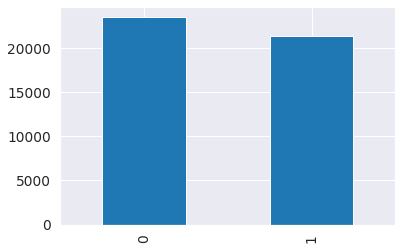

In [0]:
merged_data['label'].value_counts().plot(kind="bar")
plt.show()

# Pre-processing

In [0]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [0]:
merged_data['clean_text'] = merged_data['text'].map(lambda x: clean_text(x))
merged_data.head(3)

,title,text,subject,date,label,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...


## Count common words in article

In [0]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in merged_data.iterrows():
    c = Counter(row['clean_text'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

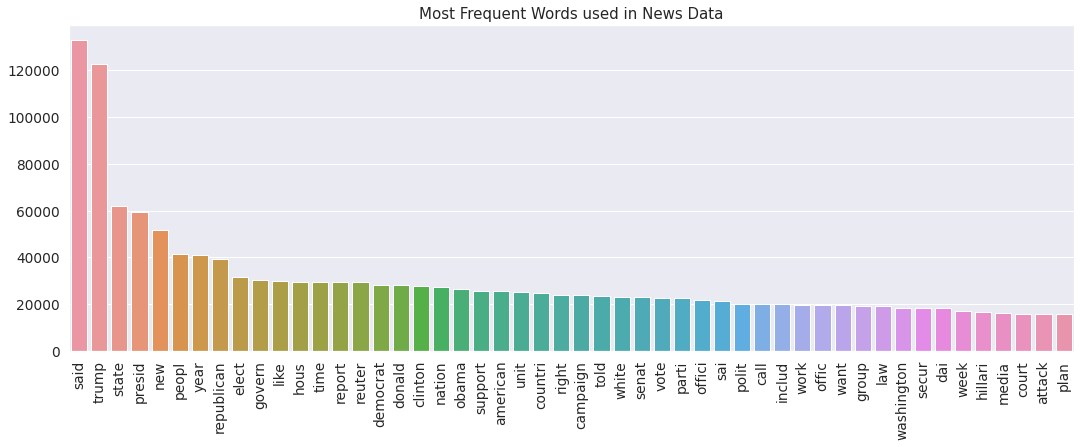

In [0]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in News Data')

## Uncommon words in News article

In [0]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]

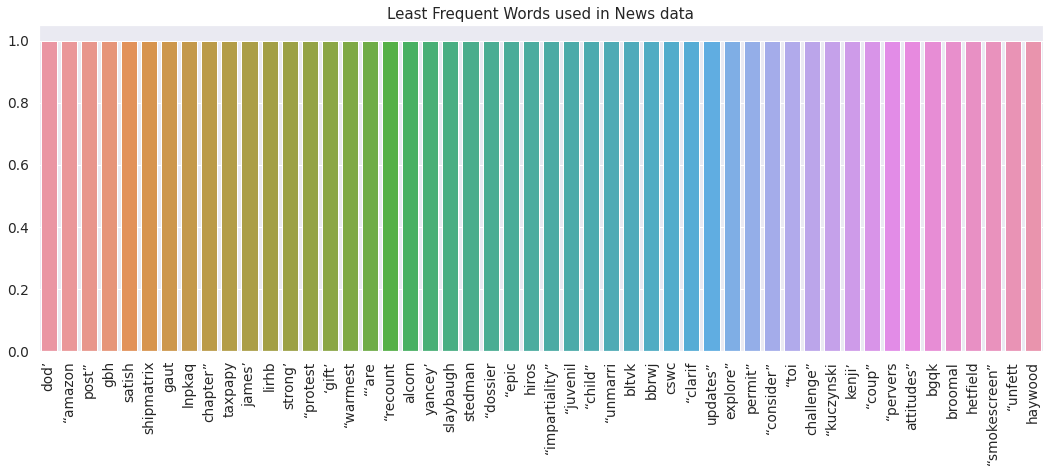

In [0]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in News data')

# Visualizations

### Wordcloud

In [0]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def word_cloud_visualization(df):
    text = " ".join(ht for ht in df.title)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

True Data Word Cloud Visualization


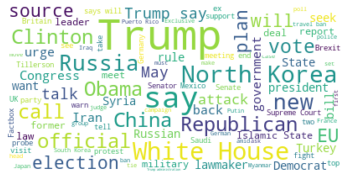

Fake Data Word Cloud Visualization


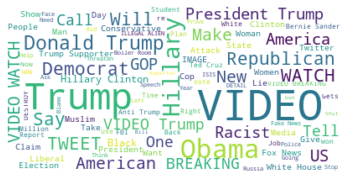

In [0]:
print('True Data Word Cloud Visualization')
word_cloud_visualization(true_data)

print('Fake Data Word Cloud Visualization')
word_cloud_visualization(fake_data)

### t-SNE Model and graph

In [0]:
from gensim.models import word2vec

num_features = 15      # Word vector dimensionality                      
min_word_count = 100   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

#Create Word2Vec Model. Get Vector from the model
word_tokens = []
for i in range(len(true_data)):
    words = true_data['title'][i].split()
    word_tokens.append(words)
    
word2vec_model = word2vec.Word2Vec(word_tokens, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

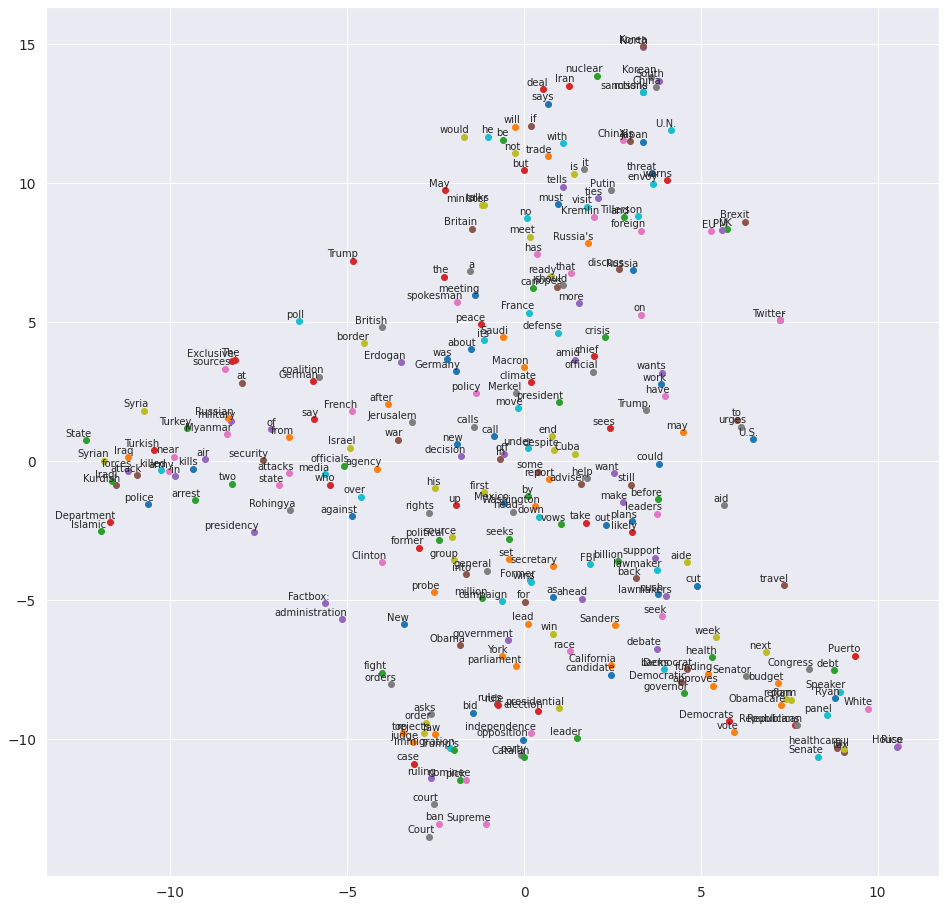

In [0]:
#"Creates and TSNE model and plots it"
from sklearn.manifold import TSNE
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

In [0]:
from gensim.models import word2vec

num_features = 15      # Word vector dimensionality                      
min_word_count = 100   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

#Create Word2Vec Model. Get Vector from the model
word_tokens = []
for i in range(len(fake_data)):
    words = fake_data['title'][i].split()
    word_tokens.append(words)
    
word2vec_model = word2vec.Word2Vec(word_tokens, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

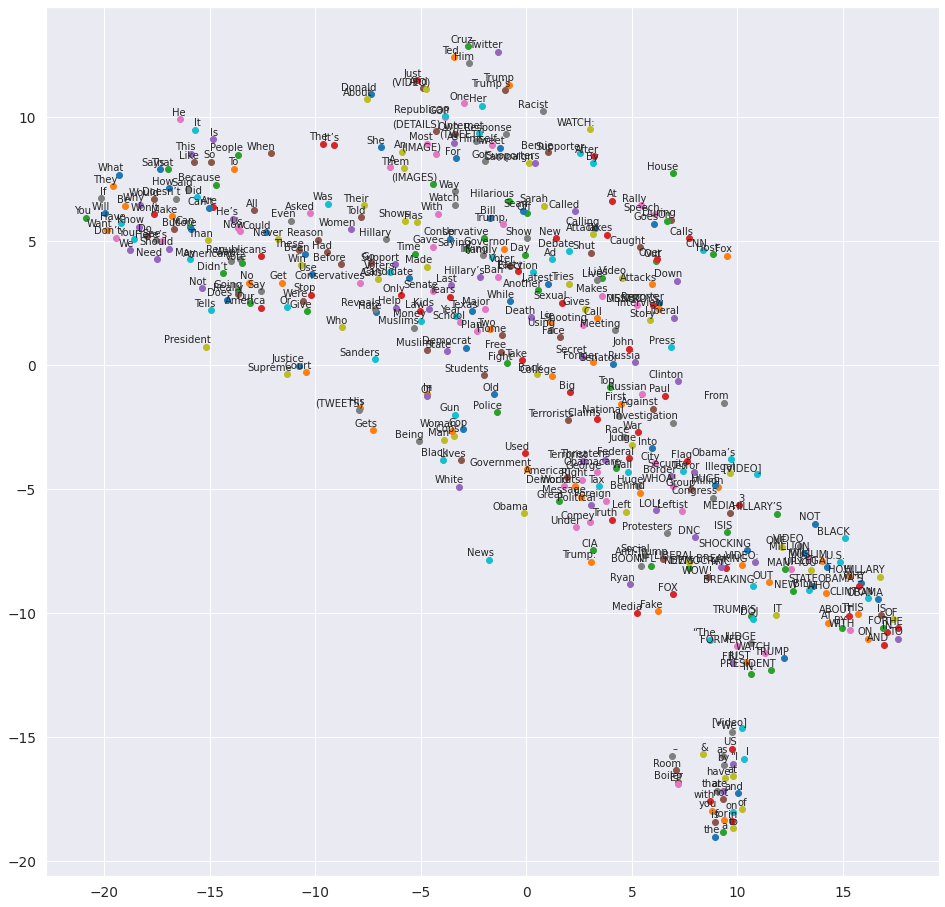

In [0]:
#"Creates and TSNE model and plots it"
from sklearn.manifold import TSNE
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(word2vec_model)

# Distillation

## Doc2Vec modeling

In [0]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20,column='clean_text'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
        self.column = column

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row[self.column]).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row[self.column]).split())
                                     for index, row in df_x.iterrows()]))

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr = Doc2VecTransformer(vector_size=10, learning_rate=0.001, epochs=10,column='clean_text')
doc2vec_tr.fit(merged_data)
doc2vec_vectors = doc2vec_tr.transform(merged_data)

100%|██████████| 44898/44898 [00:00<00:00, 3093687.65it/s]


In [0]:
doc2vec_vectors.shape

(44898, 10)

In [0]:
labels = merged_data['label'].values
labels.shape

(44898,)

## LDA Analysis

In [0]:
df_train, df_test = train_test_split(merged_data, test_size=0.2, random_state=0)


### Tf-IDF Modeling

In [0]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

X_train_text = tfidf.fit_transform(df_train['text'])
X_test_text  = tfidf.transform(df_test['text'])

In [0]:
X_train_text.shape

(35918, 2546028)

['trump', 'said', 'president', 'people', 'state', 'new', 'reuters', 'clinton', 'obama', 'donald']


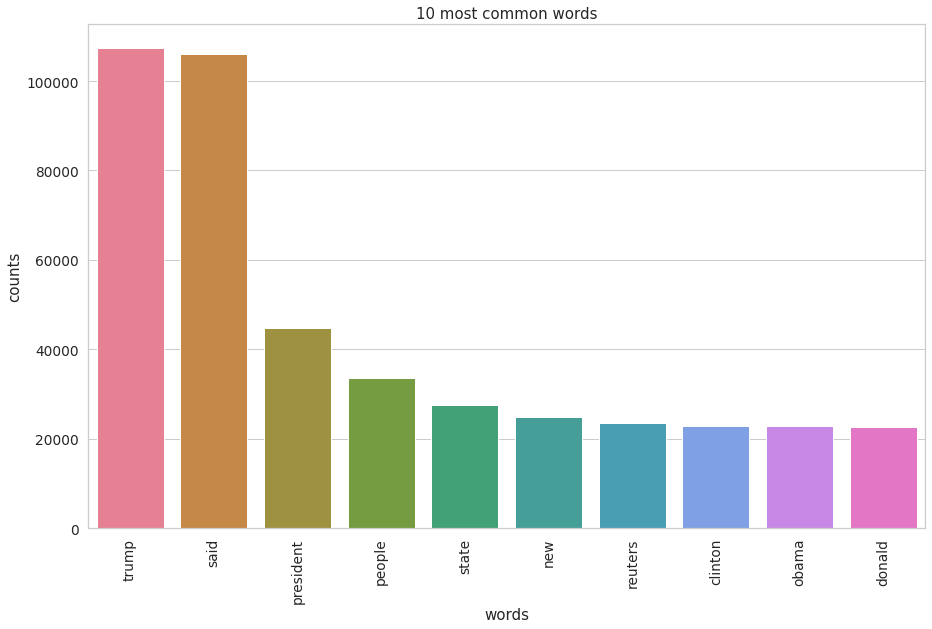

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_train['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
trump people said just like donald president don women white

Topic #1:
said trump united president north states china korea nuclear military

Topic #2:
said trump president house republican state clinton obama new senate

Topic #3:
trump news media russia russian president twitter clinton fbi intelligence

Topic #4:
said government reuters state people year party minister police told


In [0]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
merged_data.dtypes

title         object
text          object
subject       object
date          object
label          int64
clean_text    object
dtype: object

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
t1 = time.time()
merged_data['tokenized'] = merged_data['text'].apply(apply_all) + merged_data['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(merged_data), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 44898 articles: 6.386180933316549 min


In [0]:
merged_data

,title,text,subject,date,label,clean_text,tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,"[washington, reuter, head, conserv, republican..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,"[washington, reuter, transgend, peopl, allow, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,"[washington, reuter, special, counsel, investi..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,"[washington, reuter, trump, campaign, advis, g..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattl washington reuter presid donald trump c...,"[seattlewashington, reuter, presid, donald, tr..."
...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,centuri wire sai wire report earlier week unli...,"[st, centuri, wire, say, wire, report, earlier..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,centuri wire sai familiar theme disput chang l...,"[st, centuri, wire, say, familiar, theme, when..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen centuri wirerememb obama ad...,"[patrick, henningsen, st, centuri, wirerememb,..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,centuri wire sai jazeera america histori bigge...,"[st, centuri, wire, say, al, jazeera, america,..."


In [0]:
merged_data.to_csv('tokenized_data.csv',index=False)

In [0]:
from gensim import models, corpora, similarities
from gensim.models import LdaModel

def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(merged_data), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [0]:
dictionary,corpus,lda = train_lda(merged_data)


Time to train LDA model on  44898 articles:  2.9533305088678996 min


In [0]:
len(dictionary)

175486

In [0]:
lda.show_topics(num_topics=10, num_words=20)


[(0,
  '0.009*"compani" + 0.009*"new" + 0.009*"us" + 0.007*"centuri" + 0.007*"st" + 0.006*"one" + 0.006*"work" + 0.005*"govern" + 0.005*"busi" + 0.005*"also" + 0.005*"use" + 0.005*"year" + 0.005*"would" + 0.005*"corpor" + 0.004*"bank" + 0.004*"wall" + 0.004*"global" + 0.004*"oper" + 0.004*"million" + 0.004*"industri"'),
 (1,
  '0.032*"elect" + 0.025*"democrat" + 0.022*"vote" + 0.020*"parti" + 0.015*"candid" + 0.014*"state" + 0.014*"campaign" + 0.013*"polit" + 0.012*"clinton" + 0.012*"voter" + 0.012*"support" + 0.011*"presidenti" + 0.011*"republican" + 0.010*"sander" + 0.009*"hillari" + 0.008*"poll" + 0.008*"rubio" + 0.007*"win" + 0.007*"berni" + 0.006*"new"'),
 (2,
  '0.023*"law" + 0.022*"immigr" + 0.020*"court" + 0.019*"state" + 0.017*"illeg" + 0.013*"feder" + 0.012*"order" + 0.012*"right" + 0.011*"us" + 0.011*"judg" + 0.010*"justic" + 0.009*"legal" + 0.009*"rule" + 0.009*"muslim" + 0.008*"case" + 0.008*"govern" + 0.007*"countri" + 0.007*"refuge" + 0.007*"would" + 0.007*"border"'),
 (

In [0]:
lda.save('/content/drive/My Drive/model2/lda.model')


In [0]:
merged_data.loc[merged_data.index == 0]

,title,text,subject,date,label,clean_text,tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,"[washington, reuter, head, conserv, republican..."


## Add LDA Topics to dataframe 

In [0]:
merged_data['lda_topics'] = ''

In [0]:
def getKey(item):
  return item[1]



corpus = [dictionary.doc2bow(doc) for doc in merged_data['tokenized']]
for i in range(0,len(corpus)):
  list = lda[corpus[i]] # corpus[0] means the first document.
  sorted_list = sorted(list, key=getKey)
  sorted_list.reverse()
  text = " ".join([dictionary[j[0]] for j in sorted_list])
  
  merged_data.loc[merged_data.index == i, ['lda_topics']] = text


In [0]:
merged_data.head()

,title,text,subject,date,label,clean_text,tokenized,lda_topics
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,"[washington, reuter, head, conserv, republican...",aid among approv administr add approach also a...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,"[washington, reuter, transgend, peopl, allow, ...",administr agre approach alreadi approv among a...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,"[washington, reuter, special, counsel, investi...",also agre approv aid approach add among alread...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,"[washington, reuter, trump, campaign, advis, g...",also agre approach add approv among alreadi ai...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattl washington reuter presid donald trump c...,"[seattlewashington, reuter, presid, donald, tr...",action among aid alreadi agre approv approach ...


## Doc2Vec for LDA topics

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vector2 = Doc2VecTransformer(vector_size=10, learning_rate=0.001, epochs=10,column='lda_topics')
doc2vector2.fit(merged_data)
doc2vec_vectors2 = doc2vector2.transform(merged_data)

100%|██████████| 44898/44898 [00:00<00:00, 2842932.68it/s]


## Sentiment Analysis

In [0]:
merged_data['negative'] = 0.0
merged_data['neutral'] = 0.0
merged_data['positive'] = 0.0
merged_data['compound'] = 0.0


In [0]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
senti = nltk.sentiment.vader.SentimentIntensityAnalyzer()

headlines = merged_data['text'].tolist()
ids = merged_data.index.tolist()
for index in range(0,len(headlines)):
    line = headlines[index]
    if not pd.isna(line):
      pol_score = senti.polarity_scores(line)
      #print(pol_score)
      id = ids[index]
      merged_data.loc[merged_data.index == id, ['negative']] = pol_score['neg']# [neg,neu,pos,compound]
      merged_data.loc[merged_data.index == id, ['neutral']] = pol_score['neu']
      merged_data.loc[merged_data.index == id, ['positive']] = pol_score['pos']
      merged_data.loc[merged_data.index == id, ['compound']] = pol_score['compound']
      if index % 1500 == 0:
        print("processing ",index,' of ',len(headlines))
        
      
merged_data.head(2)

processing  0  of  44898
processing  1500  of  44898
processing  3000  of  44898
processing  4500  of  44898
processing  6000  of  44898
processing  7500  of  44898
processing  9000  of  44898
processing  10500  of  44898
processing  12000  of  44898
processing  13500  of  44898
processing  15000  of  44898
processing  16500  of  44898
processing  18000  of  44898
processing  19500  of  44898
processing  21000  of  44898
processing  22500  of  44898
processing  24000  of  44898
processing  25500  of  44898
processing  27000  of  44898
processing  28500  of  44898
processing  30000  of  44898
processing  31500  of  44898
processing  33000  of  44898
processing  34500  of  44898
processing  36000  of  44898
processing  37500  of  44898
processing  39000  of  44898
processing  40500  of  44898
processing  42000  of  44898
processing  43500  of  44898


,title,text,subject,date,label,clean_text,tokenized,lda_topics,negative,neutral,positive,compound
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,"[washington, reuter, head, conserv, republican...",aid among approv administr add approach also a...,0.049,0.863,0.088,0.9847
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,"[washington, reuter, transgend, peopl, allow, ...",administr agre approach alreadi approv among a...,0.084,0.825,0.091,-0.0289


In [0]:
merged_data.to_csv('sentiment_isot.csv')

In [0]:
sentiment_values = merged_data[['compound','negative','neutral','positive']].values
sentiment_values.shape

(44898, 4)

## Aggregate vectors and sentiment labels

In [0]:
print(doc2vec_vectors.shape)
print(doc2vec_vectors2.shape)
print(sentiment_values.shape)
doc2vec_vectors3 = np.concatenate([doc2vec_vectors, doc2vec_vectors2,sentiment_values],axis=1)
print(doc2vec_vectors3.shape)

(44898, 10)
(44898, 10)
(44898, 4)
(44898, 24)


In [0]:
labels = merged_data['label'].values
labels.shape

(44898,)

# Classification modeling

In [0]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection._search import BaseSearchCV
import pickle as pkl

seed = 58

# perform the split which gets us the train data and the test data
news_train, news_test, labels_train, labels_test = train_test_split(doc2vec_vectors3, labels,
                                                                    test_size=0.25,
                                                                    random_state=seed,
                                                                    stratify=labels)

In [0]:
import warnings
# Ignore some unimportant warnings
warnings.filterwarnings("ignore") 
                        
from mlxtend.classifier import EnsembleVoteClassifier

from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint
from scipy.stats.distributions import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np

# MLP classifier
mlp = MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.8,
                    beta_2=0.9, early_stopping=False, epsilon=1e-08,
                    hidden_layer_sizes=(600, 300), learning_rate='constant',
                    learning_rate_init=0.0001, max_iter=500, momentum=0.9,
                    nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
                    solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
                    warm_start=False)

# KNN classifier
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
                           weights='distance')

# QDA classifier
qda = QuadraticDiscriminantAnalysis(priors=np.array([0.5, 0.5]),
                                    reg_param=0.6531083254653984, store_covariance=False,
                                     tol=0.0001)

# GDB classifier
gdb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                 learning_rate=0.1, loss='exponential', max_depth=10,
                                 max_features='log2', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=0.0012436966435001434,
                                 min_samples_split=100, min_weight_fraction_leaf=0.0,
                                 n_estimators=200, presort='auto', random_state=0,
                                 subsample=0.8, verbose=0, warm_start=False)

# SVC classifier
svc = SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
          max_iter=-1, probability=True, random_state=0, shrinking=True,
          tol=0.001, verbose=False)

# GNB classifier
gnb = GaussianNB(priors=None)

# RF classifier
rf = RandomForestClassifier(bootstrap=False, class_weight=None,
                            criterion='entropy', max_depth=10, max_features=7,
                            max_leaf_nodes=None, min_impurity_decrease=0.0,
                            min_impurity_split=None, min_samples_leaf=9,
                            min_samples_split=6, min_weight_fraction_leaf=0.0,
                            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
                            verbose=0, warm_start=False)

# LG classifier
lg = LogisticRegression(C=7.374558791, class_weight=None, dual=False,
                        fit_intercept=True, intercept_scaling=1, max_iter=100,
                        multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                        solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

classifiers_list = [mlp, knn, qda, gdb, svc, gnb, rf, lg]
model_names = ['mlp','knn', 'qda', 'gdb', 'svc', 'gnb', 'rf', 'lg']

In [0]:
from sklearn.metrics import classification_report

# print details of testing results
i = 0
for model in classifiers_list:
    model.fit(news_train, labels_train)
    labels_pred = model.predict(news_test)
    
    # Report the metrics
    target_names = ['Real', 'Fake']
    print(model.__class__.__name__)
    print(classification_report(y_true=labels_test, y_pred=labels_pred, target_names=target_names, digits=3))
    filename = model_names[i]+'.pkl'
    pkl.dump(model, open(filename, 'wb'))
    i+=1
    

MLPClassifier
              precision    recall  f1-score   support

        Real      0.663     0.546     0.599      5871
        Fake      0.583     0.696     0.634      5354

    accuracy                          0.617     11225
   macro avg      0.623     0.621     0.617     11225
weighted avg      0.625     0.617     0.616     11225

KNeighborsClassifier
              precision    recall  f1-score   support

        Real      0.622     0.639     0.630      5871
        Fake      0.592     0.574     0.583      5354

    accuracy                          0.608     11225
   macro avg      0.607     0.606     0.606     11225
weighted avg      0.607     0.608     0.608     11225

QuadraticDiscriminantAnalysis
              precision    recall  f1-score   support

        Real      0.586     0.547     0.566      5871
        Fake      0.537     0.577     0.557      5354

    accuracy                          0.561     11225
   macro avg      0.562     0.562     0.561     11225
weighted 

In [0]:
overAllTime = time.time() - startTime
print("Overall time taken to execute factor analysis : ", (overAllTime/60),' minutes')

Overall time taken to execute factor analysis :  198.40659044583637  minutes


# Factor Analysis

I have investigated 'Neutral micropatterns of mis-information' pattern. I begin with understanding the micro patterns in the news article and determine how each article varies from other in the corpus by using cosine similarity. 
The descripancies in articles yields anomaly in data and helps to determine the mis-information in the news.

**Design:**

* Preprocess Data
* Doc2Vec 
* LDA for topic modeling 
* Sentiment Analysis
* Extract All fine-grain feature and classify true and fake data using classifier models



# Data Narrative 

I began with Liar Liar dataset and Kaggle Fake news dataset as instructed in assignment, but the data has lot of mismatch and I couldn't find enough true label data to proceed further. Hence I have used ISOT news article dataset, which has 21k True labeled data and 23k fake news data.


# Model Analysis

I have verified classification will all popular classifer algorithms. The accuracies are listed below

Algorithm | Accuracy
--- | ---
MLP classifier | 61%
KNN  | 60%
Quadratic Discriminant Analysis  | 56%
Gradient Boosting Classifier  | 67%
SVC  | 61%
Random Forest Classifier  | 64%
Logistic Regression  | 61%





## Conclusion

Neural micro -patterns of misinformation factor is analyzed using word embeddings, Doc2Vec, LDA, and Sentiment analysis vectors.

**Technical Difficulty** 

* Liar Liar news articles and ISOT news articles are not amalgamated because the distance similarity didn't match between the two datasets.
* Availability of Multi-label dataset is very minimal




Reference 
* https://www.searchtechnologies.com/blog/natural-language-processing-techniques
* https://www.analyticsvidhya.com/blog/2019/12/detect-fight-neural-fake-news-nlp/ 
* https://becominghuman.ai/real-vs-fake-tweet-detection-using-a-bert-transformer-model-in-few-lines-of-code-ccc33ecb1a2 
* https://medium.com/@sthacruz/fake-news-classification-using-glove-and-long-short-term-memory-lstm-a48f1dd605ab 
* https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db 
* https://www.kaggle.com/ktattan/lda-and-document-similarity